## Import libraries

In [1]:
# импорт библиотек

import os
import glob
import json
import getpass
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from radiant_mlhub import Dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

d:\Study\magistry\sem_2\ai-system-architecture-project\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# подключение к Google Диску

# from google.colab import drive
# drive.mount('/content/drive')

## Download Data from MLHub

API Radiant MLHub предоставляет доступ к обучающим данным открытых изображений Земли для приложений машинного обучения. Больше о репозитории на [Radiant MLHub site](https://mlhub.earth)

Полная документация по API доступна на странице [docs.mlhub.earth](docs.mlhub.earth).ter/extensions/ этикетка) определение.

In [3]:
# Выбор каналов снимка (всего 12 каналов). Берем 'B09', 'B11', 'B12'

Full_bands = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 'B08','B8A', 'B09', 'B11', 'B12']

selected_bands = Full_bands[:] #+ [Full_bands[-2]] + [Full_bands[-1]] 
selected_bands

['B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B11',
 'B12']

In [4]:
# прописывание названия датасета, ресурсов, важных путей к коллекциям 

main = 'ref_agrifieldnet_competition_v1' 

assets = ['field_ids','raster_labels']

# пути к разным наборам данных (коллекциям)

source_collection = f'{main}_source'
train_label_collection = f'{main}_labels_train'
test_label_collection = f'{main}_labels_test'

In [5]:
# # Загрузка датасета через MLHUB_API_KEY
# # MLHub Key:  e9930b71821c8755aaf5ffc738a591e6770632ac2a2cf91c0d6601875b6e92a8

# os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")

# dataset = Dataset.fetch(main) # - интерфейс для скачивания набора данных с названием датасета

# # фильтр по коллекциям
# my_filter = dict(
#     ref_agrifieldnet_competition_v1_labels_train=assets,

#     ref_agrifieldnet_competition_v1_labels_test=[assets[0]], # или [assets[0]]

#     ref_agrifieldnet_competition_v1_source=selected_bands 
# )

# dataset.download(collection_filter=my_filter)

In [6]:
# архивирование папки с датасетом

# import shutil
# shutil.make_archive('data', 'tar', '/content/ref_agrifieldnet_competition_v1')

## Prepare Train Data

In [7]:
# загрузка коллекции json
with open (f'{main}/{train_label_collection}/collection.json') as f:
    train_json = json.load(f)

# получение всех уникальных идентификаторов папок в папке source для тренировочных данных  
train_folder_ids = [i['href'].split('_')[-1].split('.')[0] for i in train_json['links'][4:]]

# в соответствии с уникальными идентификаторами берем из папки train пути к файлам fields_ids.tif и raster_labels.tif
train_field_paths = [f'{main}/{train_label_collection}/{train_label_collection}_{i}/field_ids.tif' for i in train_folder_ids]
train_label_paths = [f'{main}/{train_label_collection}/{train_label_collection}_{i}/raster_labels.tif' for i in train_folder_ids]

In [8]:
#создание таблицы с уникальными идентификаторами папок в папке train и путями к этим папкам

competition_train_data = pd.DataFrame(train_folder_ids, columns=['unique_folder_id'])
competition_train_data['field_paths'] = train_field_paths
competition_train_data.head()

,unique_folder_id,field_paths
0,28852,ref_agrifieldnet_competition_v1/ref_agrifieldn...
1,d987c,ref_agrifieldnet_competition_v1/ref_agrifieldn...
2,ca1d4,ref_agrifieldnet_competition_v1/ref_agrifieldn...
3,2ec18,ref_agrifieldnet_competition_v1/ref_agrifieldn...
4,7575d,ref_agrifieldnet_competition_v1/ref_agrifieldn...


In [9]:
# сопоставление номера поля (участка) с типом культуры

def field_crop_extractor(crop_field_files):
    field_crops = {}
    tmp = crop_field_files[:len(crop_field_files)-2]
    #print(tmp)
    #for label_field_file in tqdm(crop_field_files[:len(crop_field_files) - 2]):
    for label_field_file in tqdm(tmp):
      #if int(label_fields_file) < 1000:
          with rasterio.open(f'{main}/{train_label_collection}/{train_label_collection}_{label_field_file}/field_ids.tif') as src:
              field_data = src.read()[0]
          with rasterio.open(f'{main}/{train_label_collection}/{train_label_collection}_{label_field_file}/raster_labels.tif') as src:
              crop_data = src.read()[0]
      
          for x in range(0, crop_data.shape[0]): # ширина
              for y in range(0, crop_data.shape[1]):
                  field_id = str(field_data[x][y])
                  field_crop = crop_data[x][y]

                  if field_crops.get(field_id) is None:
                      field_crops[field_id] = []

                  if field_crop not in field_crops[field_id]:
                      field_crops[field_id].append(field_crop)
      
    field_crop_map  =[[k, v[0]]  for k, v in field_crops.items() ]
    field_crop = pd.DataFrame(field_crop_map , columns=['field_id','crop_id'])

    return field_crop[field_crop['field_id']!='0']

In [10]:
# вызов функции на сопоставление номера поля (участка) с типом культуры
field_crop_pair = field_crop_extractor(train_folder_ids)
field_crop_pair.head()

100%|██████████| 1164/1164 [01:39<00:00, 11.66it/s]


,field_id,crop_id
1,757,6
2,756,6
3,1372,5
4,1374,1
5,1986,4


In [11]:
# объём данных, выделенных под обучающую выборку 
field_crop_pair.shape

(5538, 2)

In [12]:
# field_crop_pair['crop_id'].hist(bins = len(field_crop_pair['crop_id'].unique()) )

In [13]:
# распределение классов - несбалансированное
crops_stat = pd.pivot_table(field_crop_pair,
                            columns=['crop_id'],
                            aggfunc='count')

In [14]:
crops_stat

crop_id,1,2,3,4,5,6,8,9,13,14,15,16,36
field_id,2026,985,103,1641,21,162,48,293,59,14,41,16,129


<Axes: >

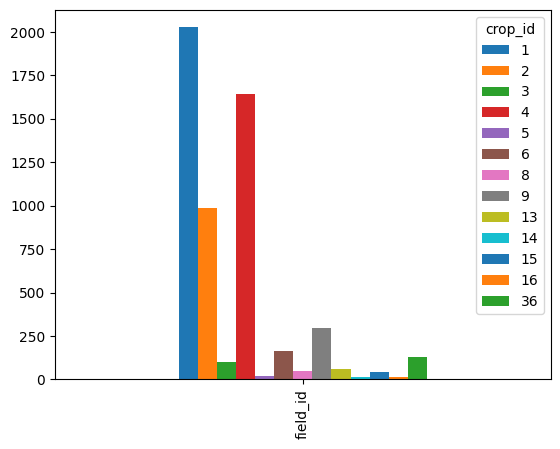

In [15]:
crops_stat.plot(kind='bar')

In [16]:
# # номера классов 
# field_crop_pair['crop_id'].unique()

In [17]:
# Создание переменной X таким образом, чтобы каждая строка являлась пикселем, 
# а каждый столбец - одним из наблюдаемых каналов (всего их 12), сопоставленных с соответствующим полем.

img_sh = 256
n_selected_bands= len(selected_bands)

n_obs = 1  

def feature_extractor(data_ , path):
    '''
        data_: Dataframe with 'field_paths' and 'unique_folder_id' columns
        path: Path to source collections files

        returns: pixel dataframe with corresponding field_ids
        '''
    
    X = np.empty((0, n_selected_bands * n_obs))
    X_tile = np.empty((img_sh * img_sh, 0))
    X_arrays = []
        
    field_ids = np.empty((0, 1))
    tmp = data_['unique_folder_id'][:len(data_['unique_folder_id']) - 2]
    #print(data_['unique_folder_id'])
    for idx, tile_id in tqdm(enumerate(tmp)):
    #for idx, tile_id in tqdm(enumerate(data_['unique_folder_id'])):
        if(idx != 1165 and idx != 1166):
          field_src =   rasterio.open( data_['field_paths'].values[idx])
          #print(field_src)
          field_array = field_src.read(1)
          field_ids = np.append(field_ids, field_array.flatten())
          
          
          bands_src = [rasterio.open(f'{main}/{path}/{path}_{tile_id}/{band}.tif') for band in selected_bands]
          bands_array = [np.expand_dims(band.read(1).flatten(), axis=1) for band in bands_src]
          
          X_tile = np.hstack(bands_array)

          X_arrays.append(X_tile)
        

    X = np.concatenate(X_arrays)
    
    data = pd.DataFrame(X, columns=selected_bands)

    data['field_id'] = field_ids

    return data[data['field_id']!=0]

In [18]:
# сопоставление номера поля с значениями пикселей, которые находятся в этом поле для каждого канала 
train_data = feature_extractor(competition_train_data, source_collection)
train_data.head()

1164it [01:49, 10.67it/s]


,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id
11031,43,39,38,38,41,54,63,61,64,12,57,37,757.0
11287,43,39,38,38,42,57,67,63,72,12,63,42,757.0
11288,43,39,38,37,41,59,69,65,78,12,68,43,757.0
11289,43,38,37,36,41,59,69,64,78,12,68,43,757.0
11543,43,39,38,38,42,57,67,64,72,12,63,42,757.0


In [19]:
# общее кол-во пикселей для всех полей
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187952 entries, 11031 to 76230400
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   B01       187952 non-null  uint8  
 1   B02       187952 non-null  uint8  
 2   B03       187952 non-null  uint8  
 3   B04       187952 non-null  uint8  
 4   B05       187952 non-null  uint8  
 5   B06       187952 non-null  uint8  
 6   B07       187952 non-null  uint8  
 7   B08       187952 non-null  uint8  
 8   B8A       187952 non-null  uint8  
 9   B09       187952 non-null  uint8  
 10  B11       187952 non-null  uint8  
 11  B12       187952 non-null  uint8  
 12  field_id  187952 non-null  float64
dtypes: float64(1), uint8(12)
memory usage: 5.0 MB


In [20]:
# Каждое поле имеет несколько пикселей в данных. Здесь наша цель — построить модель случайного леса (RF), используя средние значения
# пикселей в каждом поле. С помощью `groupby` получаем среднее значение для каждого field_id.

train_data_grouped = train_data.groupby(['field_id']).mean().reset_index()
train_data_grouped.field_id = [str(int(i)) for i in train_data_grouped.field_id.values]
train_data_grouped.head()

,field_id,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12
0,1,45.000000,42.444444,42.722222,48.000000,49.666667,58.000000,65.222222,60.277778,71.944444,12.000000,80.277778,61.333333
1,2,45.000000,42.000000,42.166667,47.666667,49.250000,59.916667,69.000000,63.916667,76.333333,12.833333,79.916667,56.750000
2,3,45.000000,42.687500,43.500000,49.187500,51.437500,62.875000,71.625000,66.625000,79.312500,13.000000,82.125000,58.062500
3,4,45.866667,42.466667,43.800000,47.733333,49.466667,59.733333,68.133333,62.600000,73.466667,11.266667,77.600000,55.000000
4,5,46.000000,43.238095,45.238095,49.285714,50.904762,60.904762,68.952381,63.380952,74.547619,11.333333,77.452381,55.809524


In [21]:
# кол-во полей
train_data_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5538 entries, 0 to 5537
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   field_id  5538 non-null   object 
 1   B01       5538 non-null   float64
 2   B02       5538 non-null   float64
 3   B03       5538 non-null   float64
 4   B04       5538 non-null   float64
 5   B05       5538 non-null   float64
 6   B06       5538 non-null   float64
 7   B07       5538 non-null   float64
 8   B08       5538 non-null   float64
 9   B8A       5538 non-null   float64
 10  B09       5538 non-null   float64
 11  B11       5538 non-null   float64
 12  B12       5538 non-null   float64
dtypes: float64(12), object(1)
memory usage: 562.6+ KB


In [22]:
# Объединение таблиц train_data и field_crop_pair

train_df = pd.merge(train_data_grouped, field_crop_pair , on='field_id' )
train_df.head()

,field_id,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,crop_id
0,1,45.000000,42.444444,42.722222,48.000000,49.666667,58.000000,65.222222,60.277778,71.944444,12.000000,80.277778,61.333333,1
1,2,45.000000,42.000000,42.166667,47.666667,49.250000,59.916667,69.000000,63.916667,76.333333,12.833333,79.916667,56.750000,1
2,3,45.000000,42.687500,43.500000,49.187500,51.437500,62.875000,71.625000,66.625000,79.312500,13.000000,82.125000,58.062500,1
3,4,45.866667,42.466667,43.800000,47.733333,49.466667,59.733333,68.133333,62.600000,73.466667,11.266667,77.600000,55.000000,2
4,5,46.000000,43.238095,45.238095,49.285714,50.904762,60.904762,68.952381,63.380952,74.547619,11.333333,77.452381,55.809524,2


In [23]:
# train_df.corr()

C:\Users\solod\AppData\Local\Temp\ipykernel_19720\3801344954.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot=True, fmt=".2f")


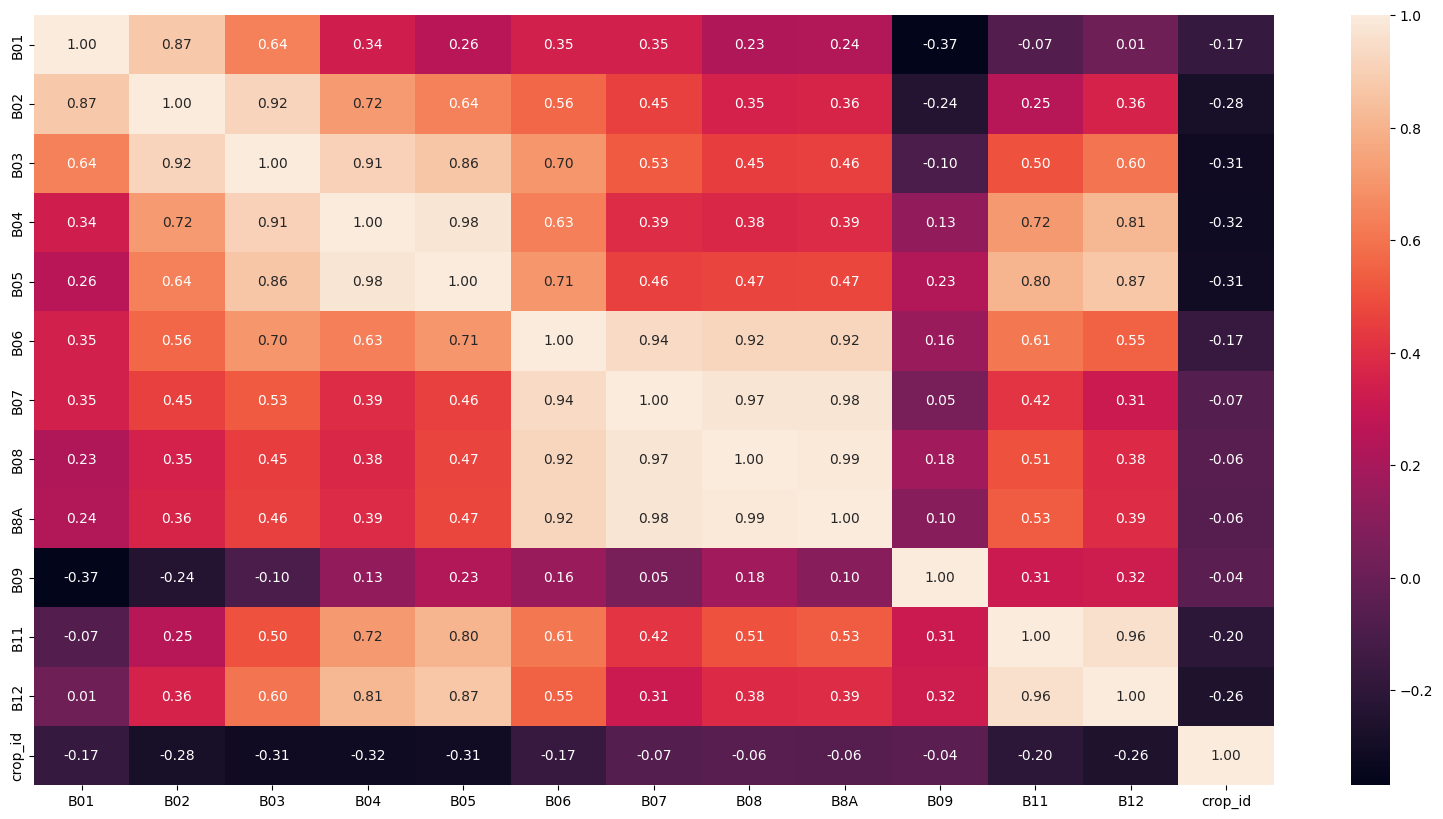

In [24]:
figure, axes = plt.subplots(figsize=(20,10))
# annot=True - отображение чисел
sns.heatmap(train_df.corr(), annot=True, fmt=".2f")
plt.show()


In [25]:
# последние 8 строчек таблицы 
train_df.tail(8)

,field_id,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,crop_id
5530,7322,45.000000,36.500000,32.250000,26.750000,31.000000,54.000000,67.875000,64.500000,75.000000,13.000000,49.625000,26.750000,4
5531,7323,45.000000,36.000000,31.000000,24.090909,27.818182,56.363636,75.454545,71.090909,82.181818,13.000000,41.909091,20.909091,4
5532,7324,45.000000,36.533333,31.666667,25.333333,29.133333,55.333333,70.800000,67.400000,77.600000,13.866667,43.066667,21.466667,4
5533,7326,46.384615,39.000000,34.576923,30.653846,33.153846,51.076923,62.538462,59.269231,66.846154,12.461538,50.615385,33.923077,9
5534,7327,46.000000,37.851852,32.629630,26.555556,29.296296,51.185185,65.518519,63.925926,70.444444,12.777778,40.740741,21.518519,9
5535,7328,47.000000,40.100000,35.100000,29.650000,31.950000,51.600000,65.050000,60.550000,70.700000,11.000000,39.550000,20.000000,9
5536,7331,46.652174,40.130435,35.130435,30.000000,32.608696,52.347826,66.347826,62.608696,71.521739,11.000000,44.434783,25.217391,9
5537,7332,46.076923,39.653846,35.230769,29.423077,31.846154,49.615385,58.615385,53.346154,60.923077,10.461538,35.538462,18.615385,36


In [26]:
train_df.shape

(5538, 14)

In [31]:
train_df.to_csv('prepared_data.csv', index=False)

In [32]:
train_df.to_excel('prepared_data.xlsx')